# <span class="title-section w3-xxlarge" id="outline">Libraries 📚</span>
<hr>

#### Code starts here ⬇

In [4]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import gresearch_crypto
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from scipy.stats import pearsonr
from tensorflow.keras import layers
from sklearn.metrics import r2_score
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
pd.set_option('display.max_columns', None)

# <span class="title-section w3-xxlarge" id="config">Configuration 🎚️</span>
<hr >

* DEVICE - is CPU or GPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* LOAD_STRICT - This controls whether to load strict at proposed [here](https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm)
* INC2021 - This controls whether to include the extra historical prices during 2021.
* INC2020 - This controls whether to include the extra historical prices during 2020.
* INC2019 - This controls whether to include the extra historical prices during 2019.
* INC2018 - This controls whether to include the extra historical prices during 2018.
* INC2017 - This controls whether to include the extra historical prices during 2017.
* INCCOMP - This controls whether to include the original data of the competition.
* INCSUPP - This controls whether to include the supplemented train data that was released with the competition.
* N_ESTIMATORS - is a list of length FOLDS. These are n_estimators for each fold. For maximum speed, it is best to use the smallest number of estimators as your GPU or CPU allows.
* MAX_DEPTH - is a list of length FOLDS. These are max_depth for each fold. For maximum speed, it is best to use the smallest number of estimators as your GPU or CPU allows.
* LEARNING_RATE - is a list of length FOLDS. These are max_depth for each fold.

In [5]:
DEVICE = "GPU" #or "TPU"

SEED = 42

# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
LOAD_STRICT = True

# WHICH YEARS TO INCLUDE? YES=1 NO=0
INC2021 = 0
INC2020 = 0
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

# TRAINING PARAMETERS
EPOCHS = 4
DEBUG = True
N_ASSETS = 14
WINDOW_SIZE = 15
BATCH_SIZE = 1024
PCT_VALIDATION = 10 # last 10% of the data are used as validation set

In [6]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except: print("failed to initialize TPU")
    else: DEVICE = "GPU"

if DEVICE != "TPU": strategy = tf.distribute.get_strategy()
if DEVICE == "GPU": print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Num GPUs Available:  0


# <span class="title-section w3-xxlarge" id="loading">Data Loading 🗃️</span>
<hr>

The data organisation has already been done and saved to Kaggle datasets. Here we choose which years to load. We can use either 2017, 2018, 2019, 2020, 2021, Original, Supplement by changing the `INC2021`, `INC2020`, `INC2019`, `INC2018`, `INC2017`, `INCCOMP`, `INCSUPP` variables in the preceeding code section. These datasets are discussed [here][1].

[1]: https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285726


In [7]:
import datatable as dt
extra_data_files = {0: '../input/cryptocurrency-extra-data-binance-coin', 2: '../input/cryptocurrency-extra-data-bitcoin-cash', 1: '../input/cryptocurrency-extra-data-bitcoin', 3: '../input/cryptocurrency-extra-data-cardano', 4: '../input/cryptocurrency-extra-data-dogecoin', 5: '../input/cryptocurrency-extra-data-eos-io', 6: '../input/cryptocurrency-extra-data-ethereum', 7: '../input/cryptocurrency-extra-data-ethereum-classic', 8: '../input/cryptocurrency-extra-data-iota', 9: '../input/cryptocurrency-extra-data-litecoin', 11: '../input/cryptocurrency-extra-data-monero', 10: '../input/cryptocurrency-extra-data-maker', 12: '../input/cryptocurrency-extra-data-stellar', 13: '../input/cryptocurrency-extra-data-tron'}

# Uncomment to load the original csv [slower]
# orig_df_train = pd.read_csv(data_path + 'train.csv') 
# supp_df_train = pd.read_csv(data_path + 'supplemental_train.csv')
# df_asset_details = pd.read_csv(data_path  + 'asset_details.csv').sort_values("Asset_ID")

orig_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_train.jay').to_pandas()
df_asset_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
supp_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas()
assets_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
asset_weight_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Weight'].tolist()[idx] for idx in range(len(assets_details))}
asset_name_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Asset_Name'].tolist()[idx] for idx in range(len(assets_details))}

def load_training_data_for_asset(asset_id, load_jay = True):
    dfs = []
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())
    
    if load_jay:
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.jay').to_pandas())
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.jay').to_pandas())
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.jay').to_pandas())
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.jay').to_pandas())
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.jay').to_pandas())
    else: 
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
    if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
    df = df.sort_values('date')
    return df

def load_data_for_all_assets():
    dfs = []
    for asset_id in list(extra_data_files.keys()): dfs.append(load_training_data_for_asset(asset_id))
    return pd.concat(dfs)

In [8]:
train = load_data_for_all_assets().sort_values('timestamp').set_index("timestamp")
if DEBUG: train = train[10000000:]

In [9]:
test = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_test.jay').to_pandas()
sample_prediction_df = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_sample_submission.jay').to_pandas()
assets = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
assets_order = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas().Asset_ID[:N_ASSETS]

assets_order = dict((t,i) for i,t in enumerate(assets_order))
print("Loaded all data!")

Loaded all data!


# <span class="title-section w3-xxlarge" id="features">Feature Engineering 🔬</span>
<hr>

This notebook uses upper_shadow, lower_shadow, high_div_low, open_sub_close, seasonality/datetime features first shown in this notebook [here][1] and successfully used by julian3833 [here][2].

Additionally we can decide to use external data by changing the variables `INC2021`, `INC2020`, `INC2019`, `INC2018`, `INC2017`, `INCCOMP`, `INCSUPP` in the preceeding code section. These variables respectively indicate whether to load last year 2021 data and/or year 2020, 2019, 2018, 2017, the original, supplemented data. These datasets are discussed [here][3]

Consider experimenting with different feature engineering and/or external data. The code to extract features out of the dataset is taken from julian3833' notebook [here][2]. Thank you julian3833, this is great work.

[1]: https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition
[2]: https://www.kaggle.com/julian3833
[3]: TBD

In [10]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


In [ ]:
# CANT USE "VWAP", "COUNT"

In [11]:
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

def get_features(df, row = False):
    df_feat = df
    df_feat['spread'] = df_feat['High'] - df_feat['Low']
#     df_feat['mean_trade'] = df_feat['Volume']/df_feat['Count']
    df_feat['log_price_change'] = np.log(df_feat['Close']/df_feat['Open'])
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat['trade'] = df_feat['Close'] - df_feat['Open']
#     df_feat['gtrade'] = df_feat['trade'] / df_feat['Count']
    df_feat['shadow1'] = df_feat['trade'] / df_feat['Volume']
    df_feat['shadow3'] = df_feat['upper_Shadow'] / df_feat['Volume']
    df_feat['shadow5'] = df_feat['lower_Shadow'] / df_feat['Volume']
#     df_feat['diff1'] = df_feat['Volume'] - df_feat['Count']
    df_feat['mean1'] = (df_feat['shadow5'] + df_feat['shadow3']) / 2
    df_feat['mean2'] = (df_feat['shadow1'] + df_feat['Volume']) / 2
#     df_feat['mean3'] = (df_feat['trade'] + df_feat['gtrade']) / 2
#     df_feat['mean4'] = (df_feat['diff1'] + df_feat['upper_Shadow']) / 2
#     df_feat['mean5'] = (df_feat['diff1'] + df_feat['lower_Shadow']) / 2
    df_feat['UPS'] = (df_feat['High'] - np.maximum(df_feat['Close'], df_feat['Open']))
    df_feat['UPS'] = df_feat['UPS']
    df_feat['LOS'] = (np.minimum(df_feat['Close'], df_feat['Open']) - df_feat['Low'])
    df_feat['LOS'] = df_feat['LOS']
#     df_feat['RNG'] = ((df_feat['High'] - df_feat['Low']) / df_feat['VWAP'])
#     df_feat['RNG'] = df_feat['RNG']
#     df_feat['MOV'] = ((df_feat['Close'] - df_feat['Open']) / df_feat['VWAP'])
#     df_feat['MOV'] = df_feat['MOV']
#     df_feat['CLS'] = ((df_feat['Close'] - df_feat['VWAP']) / df_feat['VWAP'])
#     df_feat['CLS'] = df_feat['CLS']
    df_feat['LOGVOL'] = np.log(1. + df_feat['Volume'])
    df_feat['LOGVOL'] = df_feat['LOGVOL']
#     df_feat['LOGCNT'] = np.log(1. + df_feat['Count'])
#     df_feat['LOGCNT'] = df_feat['LOGCNT']
    df_feat["Close/Open"] = df_feat["Close"] / df_feat["Open"]
    df_feat["Close-Open"] = df_feat["Close"] - df_feat["Open"]
    df_feat["High-Low"] = df_feat["High"] - df_feat["Low"]
    df_feat["High/Low"] = df_feat["High"] / df_feat["Low"]
    if row: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean()
    else: df_feat['Mean'] = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis = 1)
    df_feat["High/Mean"] = df_feat["High"] / df_feat["Mean"]
    df_feat["Low/Mean"] = df_feat["Low"] / df_feat["Mean"]
#     df_feat["Volume/Count"] = df_feat["Volume"] / (df_feat["Count"] + 1)
    mean_price = df_feat[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df_feat[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df_feat['high2mean'] = df_feat['High'] / mean_price
    df_feat['low2mean'] = df_feat['Low'] / mean_price
    df_feat['high2median'] = df_feat['High'] / median_price
    df_feat['low2median'] = df_feat['Low'] / median_price
#     df_feat['volume2count'] = df_feat['Volume'] / (df_feat['Count'] + 1)
    return df_feat

train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']] = train[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target']].astype(np.float32)
print(train.shape)
train['Target'] = train['Target'].fillna(0)
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()
del df
train = get_features(train)
train_features = [i for i in train.columns if i not in ['Target', 'date', 'timestamp', 'Asset_ID', 'groups']]

(12221694, 10)


# <span class="title-section w3-xxlarge" id="modelconf">Building a Time Series Model ⚙️</span>
<hr> 

This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers.

### Load and prepare the data

In [12]:
train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()
train.shape

(12962516, 47)

In [13]:
# Matching records and marking generated rows as 'non-real'
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train['is_real'] = train.id.isin(ids) * 1
train = train.drop('id', axis=1)

In [14]:
# Features values for 'non-real' rows are set to zeros
features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real == 0, features] = 0.

In [15]:
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
train = reduce_mem_usage(train)
train.head(20)
gc.collect()

Memory usage of dataframe is 2916.95 MB
Memory usage after optimization is: 1903.43 MB
Decreased by 34.7%


0

In [16]:
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)
features = train.columns.drop(['Asset_ID', 'Target', 'group_num', 'is_real', 'date'])
train = train[features]
train = train.values
train = train.reshape(-1, N_ASSETS, train.shape[-1])
train = np.mean(train, axis = -1)

### Dataset creation
Samples with a duration of WINDOW_SIZE records (minutes) will be formed from the `train` array. Each sample has a target vector corresponding to the final index if WINDOW_SIZE record.
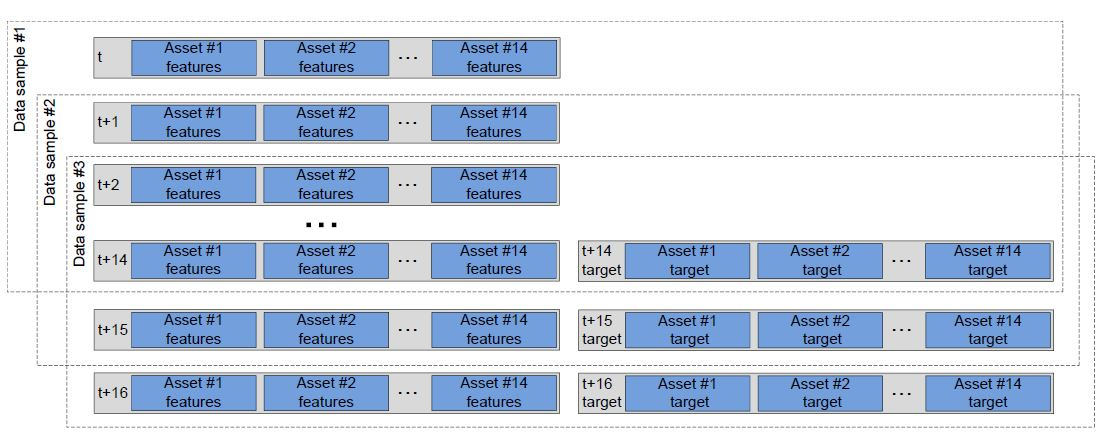

In [17]:
class sample_generator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, length):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.length = length
        self.size = len(x_set)
    def __len__(self): return int(np.ceil(len(self.x) / float(self.batch_size)))
    def __getitem__(self, idx):
        batch_x=[]
        batch_y=[]
        for i in range(self.batch_size):
            start_ind = self.batch_size*idx + i
            end_ind = start_ind + self.length 
            if end_ind <= self.size:
                batch_x.append(self.x[start_ind : end_ind])
                batch_y.append(self.y[end_ind -1])    
        return np.array(batch_x), np.array(batch_y)

In [18]:
X_train, X_test = train[:-len(train)//PCT_VALIDATION], train[-len(train)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train)//PCT_VALIDATION], targets[-len(train)//PCT_VALIDATION:]

In [19]:
train_generator = sample_generator(X_train, y_train, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
print(f'Sample shape: {train_generator[0][0].shape}')
print(f'Target shape: {train_generator[0][1].shape}')

Sample shape: (1024, 15, 14)
Target shape: (1024, 14)


# <span class="title-section w3-xxlarge" id="training">Training 🏋️</span>
<hr>

Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variable `VERBOSE`. The variable `VERBOSE=1 or 2` will display the training and validation loss for each epoch as text. 

### Defining N-BEATS

In [20]:
import math
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Concatenate
from tensorflow.keras.losses import MSE
from keras.layers import Input, Dense, Lambda, Subtract, Add, Reshape
from keras.layers import Dense, Activation, Dropout, Layer, LayerNormalization, Conv1D, Input, Concatenate, Permute, Add, GlobalAvgPool1D


class NBeatsNet:
    GENERIC_BLOCK = 'generic'
    TREND_BLOCK = 'trend'
    SEASONALITY_BLOCK = 'seasonality'

    _BACKCAST = 'backcast'
    _FORECAST = 'forecast'

    def __init__(self,
                 input_dim=1,
                 exo_dim=0,
                 backcast_length=10,
                 forecast_length=2,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):

        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.thetas_dim = thetas_dim
        self.units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.input_dim = input_dim
        self.exo_dim = exo_dim
        self.input_shape = (self.backcast_length, self.input_dim)
        self.exo_shape = (self.backcast_length, self.exo_dim)
        self.output_shape = (self.forecast_length, self.input_dim)
        self.weights = {}
        self.nb_harmonics = nb_harmonics
        assert len(self.stack_types) == len(self.thetas_dim)

        x = Input(shape=self.input_shape, name='input_variable')
        x_ = {}
        for k in range(self.input_dim):
            x_[k] = Lambda(lambda z: z[..., k])(x)
        e_ = {}
        if self.has_exog():
            e = Input(shape=self.exo_shape, name='exos_variables')
            for k in range(self.exo_dim):
                e_[k] = Lambda(lambda z: z[..., k])(e)
        else:
            e = None
        y_ = {}

        for stack_id in range(len(self.stack_types)):
            stack_type = self.stack_types[stack_id]
            nb_poly = self.thetas_dim[stack_id]
            for block_id in range(self.nb_blocks_per_stack):
                backcast, forecast = self.create_block(x_, e_, stack_id, block_id, stack_type, nb_poly)
                for k in range(self.input_dim):
                    x_[k] = Subtract()([x_[k], backcast[k]])
                    if stack_id == 0 and block_id == 0:
                        y_[k] = forecast[k]
                    else:
                        y_[k] = Add()([y_[k], forecast[k]])

        for k in range(self.input_dim):
            y_[k] = Reshape(target_shape=(self.forecast_length, 1))(y_[k])
            x_[k] = Reshape(target_shape=(self.backcast_length, 1))(x_[k])
        if self.input_dim > 1:
            y_ = Concatenate()([y_[ll] for ll in range(self.input_dim)])
            x_ = Concatenate()([x_[ll] for ll in range(self.input_dim)])
        else:
            y_ = y_[0]
            x_ = x_[0]

        if self.has_exog():
            n_beats_forecast = Model([x, e], y_, name=self._FORECAST)
            n_beats_backcast = Model([x, e], x_, name=self._BACKCAST)
        else:
            n_beats_forecast = Model(x, y_, name=self._FORECAST)
            n_beats_backcast = Model(x, x_, name=self._BACKCAST)

        self.models = {model.name: model for model in [n_beats_backcast, n_beats_forecast]}
        self.cast_type = self._FORECAST

    def has_exog(self):
        # exo/exog is short for 'exogenous variable', i.e. any input
        # features other than the target time-series itself.
        return self.exo_dim > 0

    @staticmethod
    def load(filepath, custom_objects=None, compile=True):
        from tensorflow.keras.models import load_model
        return load_model(filepath, custom_objects, compile)

    def _r(self, layer_with_weights, stack_id):
        # mechanism to restore weights when block share the same weights.
        # only useful when share_weights_in_stack=True.
        if self.share_weights_in_stack:
            layer_name = layer_with_weights.name.split('/')[-1]
            try:
                reused_weights = self.weights[stack_id][layer_name]
                return reused_weights
            except KeyError:
                pass
            if stack_id not in self.weights:
                self.weights[stack_id] = {}
            self.weights[stack_id][layer_name] = layer_with_weights
        return layer_with_weights

    def create_block(self, x, e, stack_id, block_id, stack_type, nb_poly):
        # register weights (useful when share_weights_in_stack=True)
        def reg(layer):
            return self._r(layer, stack_id)

        # update name (useful when share_weights_in_stack=True)
        def n(layer_name):
            return '/'.join([str(stack_id), str(block_id), stack_type, layer_name])

        backcast_ = {}
        forecast_ = {}
        d1 = reg(Dense(self.units, activation='relu', name=n('d1')))
        d2 = reg(Dense(self.units, activation='relu', name=n('d2')))
        d3 = reg(Dense(self.units, activation='relu', name=n('d3')))
        d4 = reg(Dense(self.units, activation='relu', name=n('d4')))
        if stack_type == 'generic':
            theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = reg(Dense(self.backcast_length, activation='linear', name=n('backcast')))
            forecast = reg(Dense(self.forecast_length, activation='linear', name=n('forecast')))
        elif stack_type == 'trend':
            theta_f = theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f_b')))
            backcast = Lambda(trend_model, arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
            forecast = Lambda(trend_model, arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
        else:  # 'seasonality'
            if self.nb_harmonics:
                theta_b = reg(Dense(self.nb_harmonics, activation='linear', use_bias=False, name=n('theta_b')))
            else:
                theta_b = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = Lambda(seasonality_model,
                              arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
            forecast = Lambda(seasonality_model,
                              arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
        for k in range(self.input_dim):
            if self.has_exog():
                d0 = Concatenate()([x[k]] + [e[ll] for ll in range(self.exo_dim)])
            else:
                d0 = x[k]
            d1_ = d1(d0)
            d2_ = d2(d1_)
            d3_ = d3(d2_)
            d4_ = d4(d3_)
            theta_f_ = theta_f(d4_)
            theta_b_ = theta_b(d4_)
            backcast_[k] = backcast(theta_b_)
            forecast_[k] = forecast(theta_f_)

        return backcast_, forecast_

    def __getattr__(self, name):
        # https://github.com/faif/python-patterns
        # model.predict() instead of model.n_beats.predict()
        # same for fit(), train_on_batch()...
        attr = getattr(self.models[self._FORECAST], name)

        if not callable(attr):
            return attr

        def wrapper(*args, **kwargs):
            cast_type = self._FORECAST
            if attr.__name__ == 'predict' and 'return_backcast' in kwargs and kwargs['return_backcast']:
                del kwargs['return_backcast']
                cast_type = self._BACKCAST
            return getattr(self.models[cast_type], attr.__name__)(*args, **kwargs)

        return wrapper


def linear_space(backcast_length, forecast_length, is_forecast=True):
    ls = K.arange(-float(backcast_length), float(forecast_length), 1) / forecast_length
    return ls[backcast_length:] if is_forecast else ls[:backcast_length]


def seasonality_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.get_shape().as_list()[-1]
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    s1 = K.stack([K.cos(2 * np.pi * i * t) for i in range(p1)])
    s2 = K.stack([K.sin(2 * np.pi * i * t) for i in range(p2)])
    if p == 1:
        s = s2
    else:
        s = K.concatenate([s1, s2], axis=0)
    s = K.cast(s, np.float32)
    return K.dot(thetas, s)


def trend_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.shape[-1]
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    t = K.transpose(K.stack([t ** i for i in range(p)]))
    t = K.cast(t, np.float32)
    return K.dot(thetas, K.transpose(t))


### Training

In [21]:
def get_model(n_assets = 14):
        
    model = NBeatsNet(
    backcast_length=15, forecast_length=1, input_dim=train_generator[0][0].shape[-1],
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
    hidden_layer_units=64)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), loss = 'mae')
    return model
    
model = get_model()
print(model.inputs, model.outputs)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

[<KerasTensor: shape=(None, 15, 14) dtype=float32 (created by layer 'input_variable')>] [<KerasTensor: shape=(None, 1, 14) dtype=float32 (created by layer 'concatenate')>]


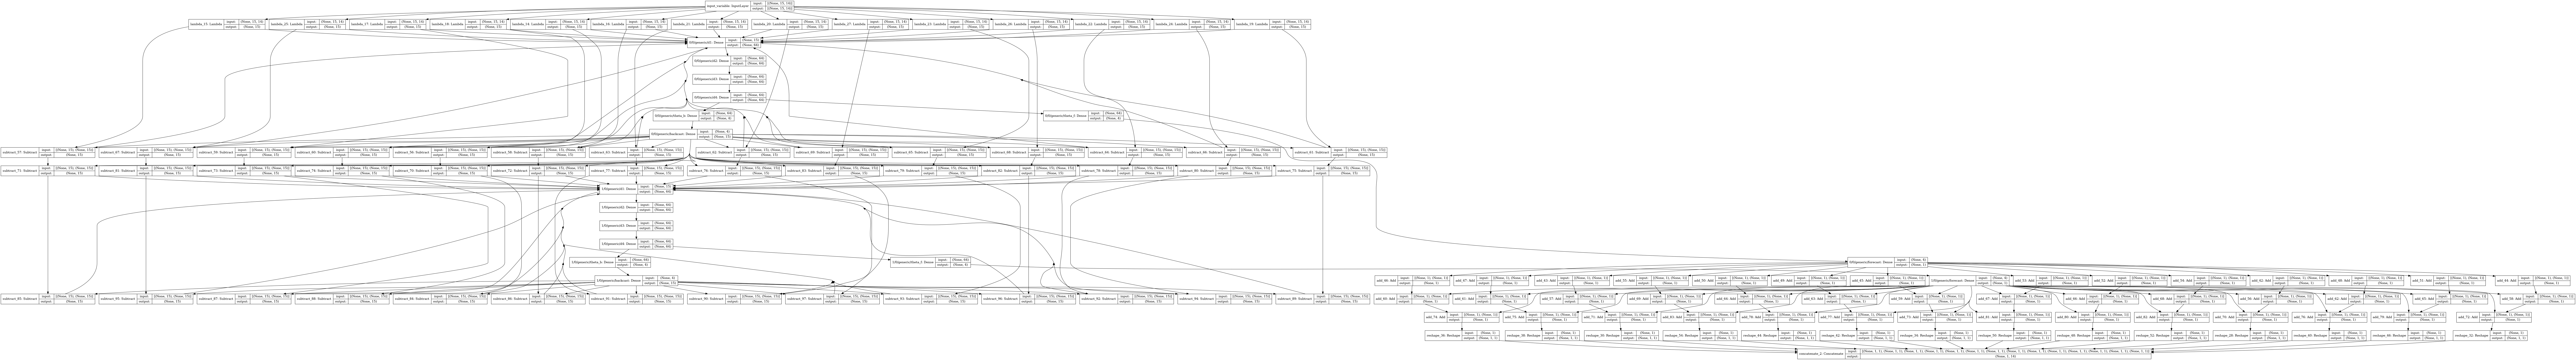

In [22]:
tf.keras.utils.plot_model(get_model(n_assets=3), show_shapes=True)

In [23]:
print(features)

tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 0, mode = 'min',restore_best_weights = True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
history = model.fit(train_generator, validation_data = (val_generator), epochs = EPOCHS, callbacks = [lr, estop])

gc.collect()

predictions = model.predict(val_generator)

print('Asset:    Corr. coef.')
print('---------------------')
for i in range(N_ASSETS):
    y_true = np.squeeze(y_test[WINDOW_SIZE - 1:, i])
    y_pred = np.squeeze(predictions[:, :, i])
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(np.nan_to_num(y_pred[real_target_ind].flatten()), np.nan_to_num(y_true[real_target_ind].flatten()))[0,1]:.4f}")

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'spread',
       'mean_trade', 'log_price_change', 'upper_Shadow', 'lower_Shadow',
       'high_div_low', 'trade', 'gtrade', 'shadow1', 'shadow3', 'shadow5',
       'diff1', 'mean1', 'mean2', 'mean3', 'mean4', 'mean5', 'UPS', 'LOS',
       'RNG', 'MOV', 'CLS', 'LOGVOL', 'LOGCNT', 'Close/Open', 'Close-Open',
       'High-Low', 'High/Low', 'Mean', 'High/Mean', 'Low/Mean', 'Volume/Count',
       'high2mean', 'low2mean', 'high2median', 'low2median', 'volume2count',
       'asset_order'],
      dtype='object')


2021-12-13 07:50:34.245547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
814/814 [==============================] - 259s 306ms/step - loss: 0.5004 - val_loss: 0.0969
Epoch 2/4

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009831635, shape=(), dtype=float32).
814/814 [==============================] - 246s 302ms/step - loss: 0.0576 - val_loss: 0.0406
Epoch 3/4

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009666104, shape=(), dtype=float32).
814/814 [==============================] - 247s 304ms/step - loss: 0.0129 - val_loss: 0.0057
Epoch 4/4

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.000950336, shape=(), dtype=float32).
814/814 [==============================] - 249s 306ms/step - loss: 0.0037 - val_loss: 0.0047
Asset:    Corr. coef.
---------------------
Cardano: 0.0014
Bitcoin Cash: 0.0043
Binance Coin: -0.0005
Bitcoin: -0.0026
Dogecoin: -0.0002
EOS.IO: -0.004

In [24]:
# Submission
# placeholder for first window_size samples
sup = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas()[:WINDOW_SIZE * (N_ASSETS)]
placeholder = get_features(sup)
placeholder['asset_order'] = placeholder.Asset_ID.map(assets_order)
test_sample = np.array(placeholder[features])
test_sample = test_sample.reshape(-1, (N_ASSETS), test_sample.shape[-1])
test_sample = np.expand_dims(test_sample, axis=0)
test_sample = np.mean(test_sample, axis = -1)

In [25]:
# for test gap filling
example = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_test.jay').to_pandas()[:WINDOW_SIZE - 1]
example['asset_order'] = example.Asset_ID.map(assets_order) 
example = example[['Asset_ID','asset_order']]

In [26]:
print(test.shape, test_sample.shape)

(56, 11) (1, 15, 14)


# <span class="title-section w3-xxlarge" id="submit">Submit To Kaggle 🇰</span>
<hr>

In [27]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df = get_features(test_df)
    test_data = test_df.merge(example, how='outer', on='Asset_ID').sort_values('asset_order')
    test = np.array(test_data[features].fillna(0))
    test = test.reshape(-1, 1, N_ASSETS, test.shape[-1])
    test = np.mean(test, axis = -1)
    test_sample = np.hstack([test_sample, test])[:,-1 * WINDOW_SIZE:]
    print(model.predict(test_sample).shape)
    y_pred = model.predict(test_sample).squeeze().reshape(-1, 1).squeeze()
    test_data['Target'] = y_pred
    for _, row in test_df.iterrows():
        try: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = test_data.loc[test_data['row_id'] == row['row_id'], 'Target'].item()
        except: sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = 0
    env.predict(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
(1, 1, 14)
(1, 1, 14)
(1, 1, 14)
(1, 1, 14)


# <span class="title-section w3-xxlarge">References</span>

<span id="f1">1.</span> [Initial baseline notebook](https://www.kaggle.com/julian3833)<br>
<span id="f2">2.</span> [Competition tutorial](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)<br>
<span id="f3">3.</span> [Competition Overview](https://www.kaggle.com/c/g-research-crypto-forecasting/overview)</span><br>
<span id="f4">4.</span> [My Initial Ideas for this competition](https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/284903)</span><br>
<span id="f5">5.</span> [My post notebook about cross validation](https://www.kaggle.com/yamqwe/let-s-talk-validation-grouptimeseriessplit)</span><br>
<span id="f5">6.</span> [Chris original notebook from SIIM ISIC](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords)</span><br>

<span class="title-section w3-large w3-tag">WORK IN PROGRESS! 🚧</span>